In [ ]:
! pip -q install transformers

In [ ]:
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm.notebook import tqdm, trange

from pathlib import Path

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoModelForCausalLM,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)

import matplotlib.pyplot as plt

#definite le costanti MODEL_CONFIG_CLASSES e MODEL_TYPES utilizzate per selezionare il tipo di modello e configurazione da utilizzare. Viene anche creato un logger per registrare eventi e messaggi nel codice.
MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [ ]:
class Args():
    def __init__(self):
        self.output_dir = 'output'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-medium'
        self.config_name = 'microsoft/DialoGPT-medium'
        self.tokenizer_name = 'microsoft/DialoGPT-medium'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = False
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.save_steps = 3500
        self.save_total_limit = None
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.seed = 42
        self.local_rank = -1


args = Args()

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#df0 = pd.read_csv('/content/drive/MyDrive/reddit_3_conversation.csv')
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')
#df = pd.read_csv('/content/drive/MyDrive/dataset6.csv')

#df = df.sample(frac=0.0001, random_state=42)
#df = df.drop('response', axis=1)
df = df.dropna()
print("len df: ",len(df))
trn_df, val_df = train_test_split(df, test_size = 0.05)
print("len trn_df: ",len(trn_df))
print("len val_df: ",len(val_df))

NameError: name 'pd' is not defined

In [ ]:
#La funzione from_pretrained viene utilizzata per caricare un tokenizer già addestrato sulla base del parametro model_name_or_path, che indica il nome del modello o il percorso in cui è stato salvato il tokenizer.
#Il parametro cache_dir viene utilizzato per specificare la cartella in cui memorizzare eventuali cache per velocizzare il caricamento dei dati.
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)

In [ ]:
#processing del dataset, ogni riga(conversazione) viene convertita in embedding ids, e ogni frase viene conclusa con il end of string token, la singola conversazione viene poi concatenata in una sola frase
#infine il dataset viene convertito in tensore(sarà poi successivamente convertito in dataloader per essere dato in input al modello)
def construct_conv(row, tokenizer, eos = True):
    #tokens=["<bot>","<speaker>"]
    flatten = lambda l: [item for sublist in l for item in sublist]
    #conv = list(reversed([tokenizer.encode(x,truncation=True,max_length=1024) + [tokenizer.eos_token_id] for x in row]))
    conv = list(reversed([tokenizer.encode(tokens[i%2]) +tokenizer.encode(x,truncation=True,max_length=1024) + [tokenizer.eos_token_id] for i, x in enumerate(row)]))
    conv = flatten(conv)
    return conv

"""def lunghezza_elemento_piu_lungo(array):
        lunghezza_massima = 0
        for elemento in array:
            lunghezza = len(elemento)
            if lunghezza > lunghezza_massima:
                lunghezza_massima = lunghezza
        return lunghezza_massima"""

class ConversationDataset(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizer, args, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)
        self.examples = []

        for _, row in df.iterrows():
            conv = construct_conv(row, tokenizer)
            if len(conv) > block_size: continue
            self.examples.append(conv)


        lunghezza_max = lunghezza_elemento_piu_lungo(self.examples)
        print("Lunghezza dell'elemento più lungo:", lunghezza_max)

    
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [ ]:
def load_examples(args, tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, args, df_val if evaluate else df_trn)

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [ ]:
# Training of model
def train(args, train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer) -> Tuple[int, float]:


    #definizione del batch size di training, che dipende dal numero di GPU utilizzate per l'addestramento.
    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)

    #creare un batch di input a partire da una lista di tensori di esempio, in modo che i tensori abbiano le stesse dimensioni all'interno del batch.
    #utilizza il metodo pad_sequence della libreria PyTorch per aggiungere padding ai tensori degli esempi più corti per renderli della stessa lunghezza di quello più lungo all'interno del batch.
    #In particolare, se il tokenizer utilizzato ha un token di padding (_pad_token), questo viene utilizzato per effettuare il padding dei tensori degli esempi più corti.
    #Altrimenti, viene utilizzato il valore di default fornito da PyTorch (padding_value=0).
    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    #campionatore casuale seleziona casualmente gli elementi dall'insieme di dati in modo che ogni epoca di addestramento possa vedere gli elementi in ordine casuale, garantendo che il modello non memorizzi l'ordine degli elementi.
    #Questo è importante perché se il modello memorizza l'ordine degli elementi, potrebbe non generalizzare bene quando si incontrano nuovi dati.
    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    #inizializza il dataloader per il set di dati di addestramento. Il dataloader carica i dati dal set di dati in batch, per consentire l'addestramento del modello in modo efficiente.
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=args.train_batch_size, collate_fn=collate, drop_last = True
    )


    #t_total viene impostato sul numero totale di batch nel dataloader di addestramento (len(train_dataloader)) moltiplicato per il numero di epoche (args.num_train_epochs).
    t_total = len(train_dataloader) * args.num_train_epochs

    #Questa parte di codice si occupa di adattare la dimensione della matrice di embedding del modello al numero di token presenti nel tokenizer.
    model.resize_token_embeddings(len(tokenizer))
    # add_special_tokens_(model, tokenizer)

    # Prepare optimizer and schedule (linear warmup and decay)
    #definisce un'istanza di un ottimizzatore AdamW e di un scheduler di apprendimento, entrambi utilizzati per l'addestramento del modello.

    no_decay = ["bias", "LayerNorm.weight"]#parametri dei modelli che non devono essere soggetti a decay durante la discesa del gradiente.
    # raggruppa i parametri del modello in base a se necessitano o meno di weight decay.
    #il weight decay è una tecnica di regolarizzazione utilizzata per prevenire l'overfitting del modello durante l'addestramento.
    #consiste nell'aggiungere una penalità alla funzione di loss in base alla norma L2 dei pesi del modello.
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)#algoritmo di ottimizzazione basato su Adam che applica weight decay solo sui parametri che richiedono l'applicazione di questo tipo di regolarizzazione.
    # definisce uno scheduler di tipo lineare con warmup, che aumenta gradualmente il tasso di apprendimento nei primi num_warmup_steps passi di addestramento e lo riduce linearmente fino a 0 in corrispondenza dell'ultimo passo.
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
    )

    #stampa alcune informazioni utili per l'addestramento del modello.
    print("***** Running training *****")
    print("  Num examples = ", len(train_dataset))
    print("  Num Epochs = ", args.num_train_epochs)
    print("  Instantaneous batch size per GPU = ", args.per_gpu_train_batch_size)
    print("  Gradient Accumulation steps = ", args.gradient_accumulation_steps)
    print("  Total optimization steps = ", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0

    tr_loss = 0.0
    # serve per azzerare i gradienti dei parametri del modello prima di eseguire il passaggio all'indietro (backward pass) durante l'addestramento.
    #Questo è necessario perché PyTorch accumula i gradienti durante il backward pass, quindi è necessario azzerarli manualmente prima di eseguire un nuovo passaggio all'indietro.
    model.zero_grad()
    #L'oggetto trange() fornisce una barra di avanzamento che indica il numero di epoche che sono state completate. L'argomento desc serve per specificare una descrizione della barra di avanzamento.
    #Il parametro disable viene utilizzato per disabilitare la barra di avanzamento se il processo non è rank 0 o se la variabile args.local_rank non è presente nel sistema.
    train_iterator = trange(
        epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
    )

    set_seed(args)  # riproducibilità
    loss_values = []
    #training starts
    for _ in train_iterator:#ciclo che scorre attraverso il numero di epoche

        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):#ciclo che scorre attraverso i dati di addestramento batch


            #Prepara i dati per l'addestramento del modello. Se la lunghezza dei dati di input è superiore a 1024, il batch viene saltato.
            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            #Carica i dati sulla GPU se disponibile.
            inputs = inputs.to(args.device)
            labels = labels.to(args.device)
            #Imposta il modello in modalità di addestramento.
            model.train()
            #Passa i dati di input al modello e ottiene l'output.
            outputs = model(inputs, labels=labels)
            #Calcola la perdita del modello (loss) in base all'output.
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            loss_values.append(loss.detach().cpu().numpy())
            #esegue la retropropagazione del gradiente
            loss.backward()

            #Aggiunge la perdita corrente (loss.item()) alla perdita totale (tr_loss).
            tr_loss += loss.item()

            #Se il numero di passi di accumulazione del gradiente è stato raggiunto (args.gradient_accumulation_steps), esegue l'ottimizzazione del modello.
            if (step + 1) % args.gradient_accumulation_steps == 0:

                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                optimizer.step()
                #Aggiorna il programma di ottimizzazione per il modello tramite la funzione scheduler.step().
                scheduler.step()  # Update learning rate schedule
                #Azzera i gradienti
                model.zero_grad()
                #Aggiorna il conteggio dei passi globali (global_step).
                global_step += 1


            #Se il numero massimo di passi di addestramento (t_total) è stato raggiunto, termina l'addestramento.
            if global_step > t_total:
                checkpoint_prefix = "checkpoint"
                output_dir = os.path.join(args.output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                os.makedirs(output_dir, exist_ok=True)
                tokenizer.save_pretrained(output_dir)
                model.save_pretrained(output_dir)
                epoch_iterator.close()
                train_iterator.close()
                break


    #Restituisce il conteggio globale dei passi (global_step) e la perdita totale dell'addestramento (tr_loss / global_step).

    # Traccia il grafico della loss
    plt.plot(loss_values)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    return global_step, tr_loss / global_step

In [ ]:
def evaluate(args, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, df_trn, df_val, prefix="") -> Dict:
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir

    eval_dataset = load_examples(args, tokenizer, df_trn, df_val, evaluate=True)
    os.makedirs(eval_output_dir, exist_ok=True)
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly

    def collate(examples: List[torch.Tensor]):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size, collate_fn=collate, drop_last = True
    )



    # Eval!
    print("***** Running evaluation {} *****".format(prefix))
    print("  Num examples = %d", len(eval_dataset))
    print("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(args.device)
        labels = labels.to(args.device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity.item()}

    output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        print("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            print( key," :", str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return result

In [ ]:
def main(df_trn, df_val):
    #args = Args()

    #Successivamente, viene controllato se l'output directory specificata dall'utente esiste già e contiene dei file, se l'utente ha richiesto di addestrare il modello,
    #se non ha specificato di sovrascrivere l'output directory e se non ha richiesto di continuare l'addestramento
    if (
        os.path.exists(args.output_dir)
        and os.listdir(args.output_dir)
        and args.do_train
        and not args.overwrite_output_dir
        and not args.should_continue
    ):
        raise ValueError(
            "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
                args.output_dir
            )
        )

    #Vengono poi configurati CUDA, la GPU e l'addestramento distribuito, se possibile. Viene inoltre configurato il logging per registrare informazioni sul processo di addestramento.
    #Viene infine caricato il modello, il tokenizer e la configurazione associata, e se richiesto viene avviato
    #l'addestramento, viene salvato il modello e i relativi dati e infine viene effettuata l'evaluazione dei risultati. I risultati dell'evaluazione vengono restituiti dalla funzione.

    device = torch.device("cuda")
    args.n_gpu = torch.cuda.device_count()
    args.device = device

    set_seed(args)

    #Questo codice carica un modello di linguaggio preaddestrato e le relative configurazioni e tokenizer
    config = AutoConfig.from_pretrained(args.config_name, cache_dir=args.cache_dir)
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, cache_dir=args.cache_dir)
    model = AutoModelForCausalLM.from_pretrained(
        args.model_name_or_path,
        from_tf=False,
        config=config,
        cache_dir=args.cache_dir,
    )
    model.to(args.device)

    #print("Training parameters ", args)

    # Training
    if args.do_train:
        train_dataset = load_examples(args, tokenizer, df_trn, df_val, evaluate=False)

        #inizia il training vero e proprio
        global_step, tr_loss = train(args, train_dataset, model, tokenizer)
        print(" global_step = ",global_step," average loss = ", tr_loss)

    #salva il modello e il tokenizer, insieme ai relativi parametri di configurazione in args.output_dir, che è la directory di output specificata nella linea 2.
    #In particolare, il modello addestrato viene salvato usando il metodo save_pretrained(), il tokenizer viene salvato usando il metodo save_pretrained(),
    #mentre i parametri di addestramento vengono salvati usando la funzione torch.save().
    #Inoltre, il modello e il tokenizer vengono caricati nuovamente dalla directory specificata per verificare che il salvataggio sia stato effettuato correttamente.
    if args.do_train:
        # Create output directory if needed
        os.makedirs(args.output_dir, exist_ok=True)

        print("Saving model to ", args.output_dir)
        #salva il modello addestrato, per ricaricarlo dopo
        model.save_pretrained(args.output_dir)
        tokenizer.save_pretrained(args.output_dir)


        torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

        # carica il modello fine tuned
        model = AutoModelForCausalLM.from_pretrained(args.output_dir)
        tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
        model.to(args.device)

        # Evaluation
    results = {}
    if args.do_eval:
        print("########Start evaluation#########")
        model = AutoModelForCausalLM.from_pretrained('output')
        model.to(args.device)
        result = evaluate(args, model, tokenizer, df_trn, df_val, prefix="")
        result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
        results.update(result)

Lunghezza dell'elemento più lungo: 441
***** Running training *****
  Num examples =  26112
  Num Epochs =  3
  Instantaneous batch size per GPU =  4
  Gradient Accumulation steps =  1
  Total optimization steps =  19584


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6528 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6528 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6528 [00:00<?, ?it/s]

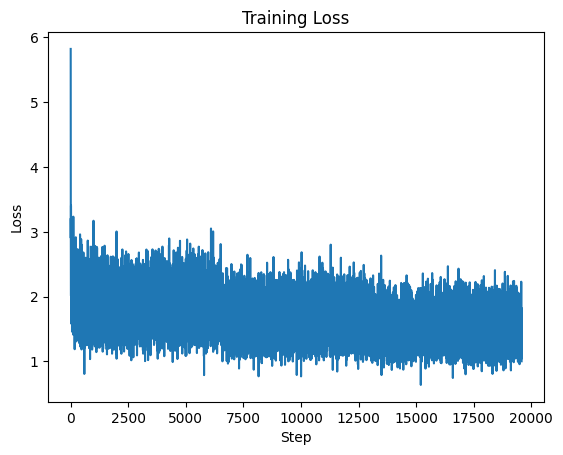

 global_step =  19584  average loss =  1.6900112037973027
Saving model to  output


In [ ]:
main(trn_df, val_df)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-medium')
model = AutoModelForCausalLM.from_pretrained('output')
#input viene codificato in token utilizzando il tokenizer fornito. Successivamente, l'input utente viene concatenato alla storia della chat (inizialmente vuota) e
#passato al modello di generazione del linguaggio per ottenere una risposta. La risposta viene quindi decodificata dal token in testo e stampata a schermo.

step=0
messaggi=[]
chatting=True
while chatting:
    # tokenizza l'user input, aggiunge eos token e restituisce tensore
    user_input = input(">>User: ")
    if user_input.lower().strip() in ['bye','quit','exit']:
        print(">>Bot: See you soon!")
        chatting=False
    else:

        new_user_input_ids = tokenizer.encode(user_input + tokenizer.eos_token, return_tensors='pt')
        messaggi.append(new_user_input_ids)
        if step>=2:
            messaggi = messaggi[2:]
        bot_input_ids = torch.cat(messaggi,dim=-1)
        # print(new_user_input_ids)

        # aggiunge l'input dell'utente alla storia della conversazione(se l'input non è il primo)
        #bot_input=
        #bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
        #print("bot input ids: ",bot_input_ids)
        """if(len(bot_input_ids[0])>length):
        bot_input_ids = torch.narrow(bot_input_ids, dim=1, start=len(bot_input_ids[0]) - length, length=length)"""

        step+=1
        #print("bot_input_ids: ",bot_input_ids)
        chat_history_ids = model.generate(
            bot_input_ids, max_length=100,
            pad_token_id=tokenizer.eos_token_id,
            top_p=0.7, top_k = 100,
            no_repeat_ngram_size=3,
            do_sample=True,
            temperature=0.8,
        )
        # stampa l'output generato dal modello
        messaggi.append(chat_history_ids[:, bot_input_ids.shape[-1]:])
        print(">>Bot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))